In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip3 install livelossplot

In [20]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as matimage
import cv2

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D, ReLU, concatenate
from keras.models import Sequential, Model
from keras import regularizers, optimizers

from livelossplot import PlotLossesKeras

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder

import os
import time
import datetime
import glob

import plotly.express as px

In [4]:
SOURCE_PATH = '/content/drive/MyDrive/PetImages'

# os.listdir returns a list containing all files under the given path
start = time.time()
CAT_PATH = os.listdir(os.path.join(SOURCE_PATH, 'Cat'))
DOG_PATH = os.listdir(os.path.join(SOURCE_PATH, 'Dog'))

CAT_PATH = list(map(lambda x : os.path.join(SOURCE_PATH+"/Cat", x), CAT_PATH))
DOG_PATH = list(map(lambda x : os.path.join(SOURCE_PATH+"/Dog", x), DOG_PATH))
end = time.time()

print(f"{len(CAT_PATH)} cats img")
print(f"{len(DOG_PATH)} dogs img")
print(f'\n{end-start} sec.')

12500 cats img
12500 dogs img

100.02148270606995 sec.


In [ ]:
# Skip here (serach for '# From here on...')

In [ ]:
df = pd.DataFrame({"path":CAT_PATH+DOG_PATH,"label":[0]*len(CAT_PATH)+[1]*len(DOG_PATH)})
df.head()

path  label
0  /content/drive/MyDrive/PetImages/Cat/8907.jpg      0
1  /content/drive/MyDrive/PetImages/Cat/9120.jpg      0
2  /content/drive/MyDrive/PetImages/Cat/8898.jpg      0
3  /content/drive/MyDrive/PetImages/Cat/9220.jpg      0
4  /content/drive/MyDrive/PetImages/Cat/9102.jpg      0

In [ ]:
df.shape

(25000, 2)

In [ ]:
def data_check():
    """
        check each image file for corrupted or missing
    """
    error = []
    start = time.time()
    for i in range(len(df)):
        try:                    # checks for corrupeted or missing image files
            if len(cv2.imread(df.iloc[i,0])) == 3:
                _ = 1
        except:
            print(i)
            error.append(df.iloc[i,0])
    end = time.time()
    print(f'\n{end-start} sec.')
    return error

In [ ]:
remove = data_check()

In [ ]:
df = df[~df["path"].isin(remove)]

In [ ]:
df.to_csv('/content/drive/MyDrive/PetImages/data.csv', index=False)

In [ ]:
# From here on...

In [5]:
df = pd.read_csv('/content/drive/MyDrive/PetImages/data.csv')

In [6]:
cd_names = ['Cat', 'Dog']
n_cats = len(df.loc[df['label']==0])
n_dogs = len(df.loc[df['label']==1])
n_images = [n_cats, n_dogs]
px.pie(names=cd_names, values=n_images).update_layout(width=300, height=300)

In [7]:
df

path  label
0       /content/drive/MyDrive/PetImages/Cat/8907.jpg      0
1       /content/drive/MyDrive/PetImages/Cat/9120.jpg      0
2       /content/drive/MyDrive/PetImages/Cat/8898.jpg      0
3       /content/drive/MyDrive/PetImages/Cat/9220.jpg      0
4       /content/drive/MyDrive/PetImages/Cat/9102.jpg      0
...                                               ...    ...
24941  /content/drive/MyDrive/PetImages/Dog/10081.jpg      1
24942  /content/drive/MyDrive/PetImages/Dog/10045.jpg      1
24943  /content/drive/MyDrive/PetImages/Dog/10100.jpg      1
24944  /content/drive/MyDrive/PetImages/Dog/10619.jpg      1
24945  /content/drive/MyDrive/PetImages/Dog/10752.jpg      1

[24946 rows x 2 columns]

In [8]:
df['path'][12475:12477]

12475    /content/drive/MyDrive/PetImages/Cat/10737.jpg
12476     /content/drive/MyDrive/PetImages/Dog/9142.jpg
Name: path, dtype: object

In [26]:
df['path'][::4]

0         /content/drive/MyDrive/PetImages/Cat/8907.jpg
4         /content/drive/MyDrive/PetImages/Cat/9102.jpg
8         /content/drive/MyDrive/PetImages/Cat/9151.jpg
12        /content/drive/MyDrive/PetImages/Cat/8862.jpg
16        /content/drive/MyDrive/PetImages/Cat/8974.jpg
                              ...                      
24928    /content/drive/MyDrive/PetImages/Dog/10203.jpg
24932    /content/drive/MyDrive/PetImages/Dog/10014.jpg
24936    /content/drive/MyDrive/PetImages/Dog/10432.jpg
24940     /content/drive/MyDrive/PetImages/Dog/1008.jpg
24944    /content/drive/MyDrive/PetImages/Dog/10619.jpg
Name: path, Length: 6237, dtype: object

In [48]:
#X_train, X_test, y_train, y_test = train_test_split(df['path'][11475:13477], df['label'][11475:13477], test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(df['path'][::2], df['label'][::2], test_size=0.1, random_state=42)

df_train = pd.DataFrame({"path":X_train,"label":y_train})
df_test = pd.DataFrame({"path":X_test,"label":y_test})

df_train['label'] = df_train['label'].astype(str)
df_test['label'] = df_test['label'].astype(str)

In [49]:
train_datagen = ImageDataGenerator(rescale=1 / 255.0, validation_split=0.20)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)

In [50]:
BATCH_SIZE = 32
IMG_WIDTH = 224
IMG_HEIGHT = 224

In [51]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=None,
    x_col="path",
    y_col="label",
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode="rgb",
    #classes=["Cat", "Dog"],   # to comment ?
    class_mode="categorical", # "categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)
valid_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=None,
    x_col="path",
    y_col="label",
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode="rgb",
    #classes=["Cat", "Dog"],   # to comment ?
    class_mode="categorical", # "categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=None,
    x_col="path",
    y_col=None, # "label"
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode="rgb", # to comment ?
    #classes=["Cat", "Dog"],
    class_mode=None, # "binary",
    batch_size=1,
    shuffle=False,
    seed=42
)

Found 8980 validated image filenames belonging to 2 classes.
Found 2245 validated image filenames belonging to 2 classes.
Found 1248 validated image filenames.


In [52]:
train_generator.filepaths[-4:]

['/content/drive/MyDrive/PetImages/Cat/11943.jpg',
 '/content/drive/MyDrive/PetImages/Cat/12052.jpg',
 '/content/drive/MyDrive/PetImages/Cat/9275.jpg',
 '/content/drive/MyDrive/PetImages/Dog/6981.jpg']

In [53]:
train_generator.classes[-4:]

[0, 0, 0, 1]

In [54]:
train_generator.class_indices

{'0': 0, '1': 1}

In [ ]:
# def prepare_model():
#     # model = Sequential()
#     # model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
#     # model.add(MaxPooling2D(pool_size=(2, 2)))
#     # model.add(Flatten())
#     # model.add(Dense(16, activation='relu'))
#     # model.add(Dense(2, activation='sigmoid'))

#     model = Sequential()
#     model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
#     #model.add(Activation('relu'))
#     # model.add(Conv2D(32, (3, 3)))
#     # model.add(Activation('relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
#     model.add(Conv2D(64, (3, 3), padding='same'))
#     model.add(Activation('relu'))
#     model.add(Conv2D(64, (3, 3)))
#     model.add(Activation('relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
#     model.add(Flatten())
#     model.add(Dense(128))
#     model.add(Activation('relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(16, activation='relu'))
#     model.add(Dense(2, activation='sigmoid'))

#     model.compile(loss="binary_crossentropy",
#                   optimizer="adam",
#                   metrics=['accuracy'])

#     return model

In [ ]:
# model = prepare_model()

In [55]:
def densenet121(input_shape, n_classes, filters = 32):

    #batch norm + relu + conv
    def bn_rl_conv(x,filters,kernel=1,strides=1):

        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel, strides=strides,padding = 'same')(x)
        return x

    def dense_block(x, repetition):

        for _ in range(repetition):
            y = bn_rl_conv(x, 4*filters)
            y = bn_rl_conv(y, filters, 3)
            x = concatenate([y,x])
        return x

    def transition_layer(x):

        x = bn_rl_conv(x, K.int_shape(x)[-1] //2 )
        x = AvgPool2D(2, strides = 2, padding = 'same')(x)
        return x

    input = Input (input_shape)
    x = Conv2D(64, 7, strides = 2, padding = 'same')(input)
    x = MaxPool2D(3, strides = 2, padding = 'same')(x)

    for repetition in [6,12,24,16]:

        d = dense_block(x, repetition)
        x = transition_layer(d)
    x = GlobalAveragePooling2D()(d)
    output = Dense(2, activation = 'sigmoid')(x)

    model = Model(input, output)

    model.compile(loss="binary_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])
    return model

In [56]:
input_shape = 224, 224, 3
model = densenet121(input_shape, 2)

In [57]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_363 (Conv2D)            (None, 112, 112, 64  9472        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 56, 56, 64)  0           ['conv2d_363[0][0]']             
                                                                                            

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.700524 to fit



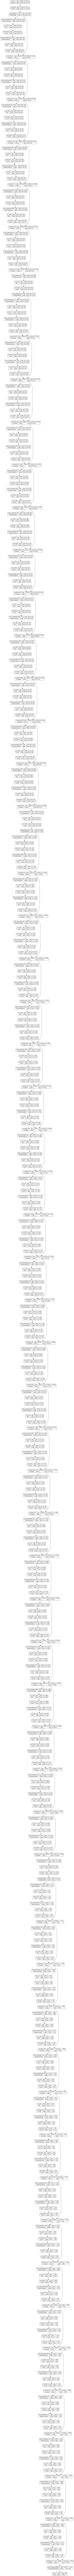

In [58]:
keras.utils.plot_model(model, show_shapes=True)

In [59]:
es_callback = tf.keras.callbacks.EarlyStopping(patience=7)

In [60]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

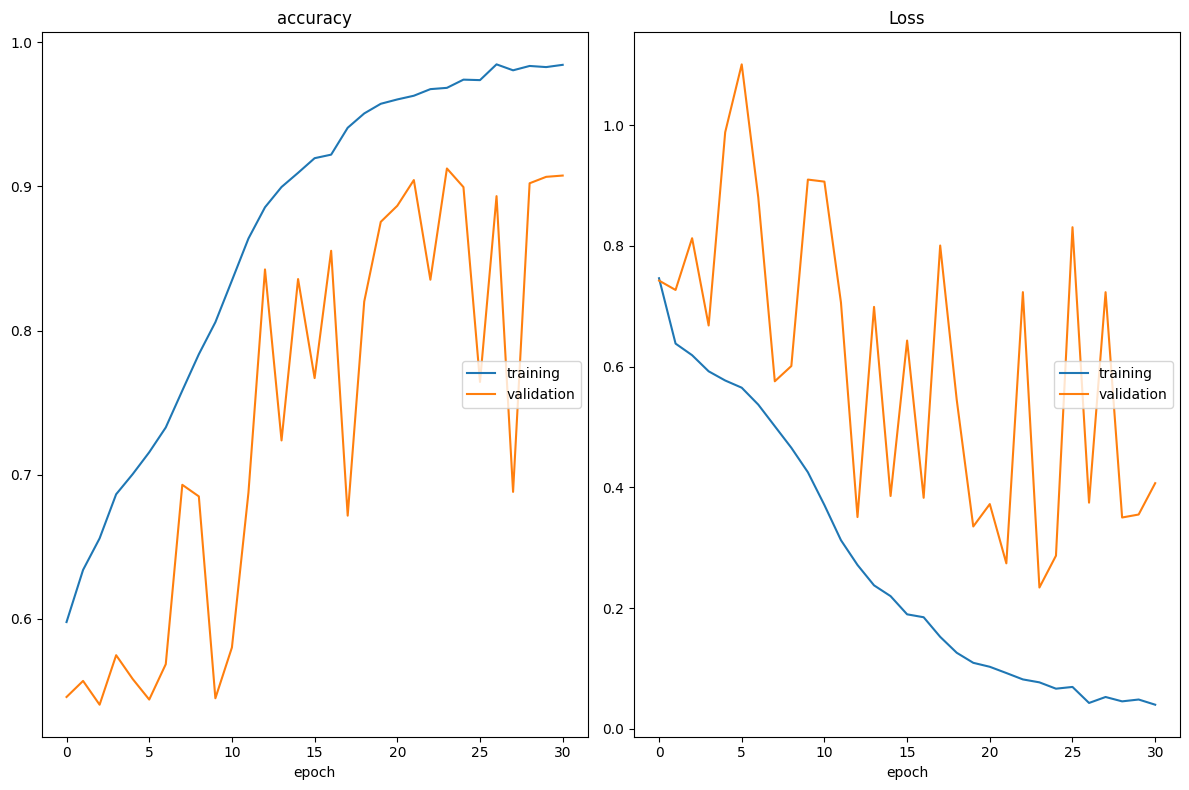

accuracy
	training         	 (min:    0.598, max:    0.985, cur:    0.984)
	validation       	 (min:    0.540, max:    0.913, cur:    0.908)
Loss
	training         	 (min:    0.040, max:    0.746, cur:    0.040)
	validation       	 (min:    0.234, max:    1.101, cur:    0.407)
280/280 [==============================] - 125s 446ms/step - loss: 0.0400 - accuracy: 0.9845 - val_loss: 0.4070 - val_accuracy: 0.9076


AttributeError: ignored

In [61]:
history = model.fit_generator(train_generator,
                              validation_data = valid_generator,
                              steps_per_epoch = STEP_SIZE_TRAIN,
                              validation_steps = STEP_SIZE_VALID,
                              use_multiprocessing = False,
                              epochs=100,
                              callbacks=[es_callback,
                                         PlotLossesKeras()]
                              )

model.save("/content/drive/MyDrive/PetImages/densenet121.h5")

In [63]:
model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID)

<ipython-input-63-22338f6c7a63>:1: UserWarning:

`Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



[0.40700942277908325, 0.9075892567634583]

In [64]:
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

test_generator.reset()
pred=model.predict_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)

<ipython-input-64-e94155cdb30c>:4: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



1248/1248 [==============================] - 327s 260ms/step


In [134]:
predicted_class_indices=np.argmax(pred, axis=1)

In [135]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [136]:
filenames = test_generator.filenames
results = pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})

In [ ]:
results['Predictions'] = results['Predictions'].astype(int)

In [140]:
results

Filename Predictions
0      /content/drive/MyDrive/PetImages/Dog/2646.jpg           1
1      /content/drive/MyDrive/PetImages/Cat/9177.jpg           0
2      /content/drive/MyDrive/PetImages/Cat/7147.jpg           0
3      /content/drive/MyDrive/PetImages/Cat/6086.jpg           0
4     /content/drive/MyDrive/PetImages/Cat/11199.jpg           1
...                                              ...         ...
1243   /content/drive/MyDrive/PetImages/Cat/8183.jpg           0
1244    /content/drive/MyDrive/PetImages/Cat/398.jpg           1
1245   /content/drive/MyDrive/PetImages/Cat/2248.jpg           0
1246   /content/drive/MyDrive/PetImages/Cat/7687.jpg           0
1247   /content/drive/MyDrive/PetImages/Cat/1882.jpg           0

[1248 rows x 2 columns]

In [154]:
class_names = ['Cat', 'Dog']

def show_25_images(images, labels):
    plt.figure(figsize=(10, 10))
    for i in range(10):
        ax = plt.subplot(2, 5, i+1)
        img = cv2.imread(images[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(class_names[labels[i]])
        plt.axis("off")

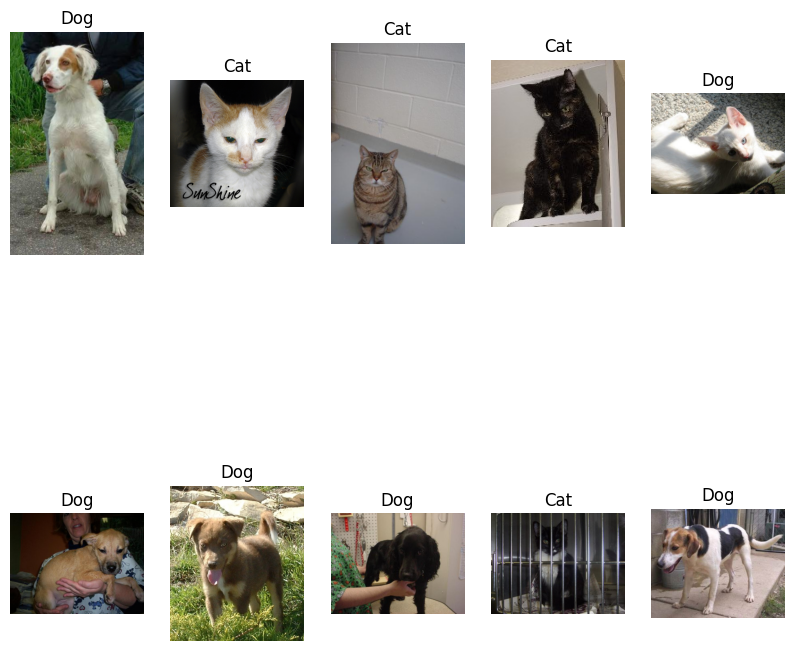

In [155]:
show_25_images(results['Filename'], results['Predictions'])